In [1]:
using thesis, PRMaps
using Healpix
using Plots
using Statistics
using LsqFit

import Stripeline as Sl
import Pandas as Pd

In [2]:
function run_scaling(
    tel_angles,
    sky_model::String,
    nside::Int
)
    
    strip = Pd.query(Pd.read_pickle("../instruments/lspe_strip_instrument.pkl"), :(frequency==43.0))
    signal = get_foreground_maps(strip, sky_model, nside)[1]

    camera = Sl.CameraAngles()
    obs_ideal, _ = makeIdealMapIQU(camera, signal, setup)
    
    obs_errored = PolarizedHealpixMap[]

    for i in tel_angles
        m, _ = makeErroredMapIQU(camera, i, signal, setup)
        push!(obs_errored, m)
    end

    error_i = [ (errored.i-obs_ideal.i) for errored in obs_errored]
    error_q = [ (errored.q-obs_ideal.q) for errored in obs_errored]
    error_u = [ (errored.u-obs_ideal.u) for errored in obs_errored]

    error_i_hist = [ i[isfinite.(i)] for i in error_i]
    error_q_hist = [ i[isfinite.(i)] for i in error_q]
    error_u_hist = [ i[isfinite.(i)] for i in error_u]

    std_error_i = [ std(i) for i in error_i_hist ]
    std_error_q = [ std(i) for i in error_q_hist ]
    std_error_u = [ std(i) for i in error_u_hist ]

    return (std_error_i, std_error_q, std_error_u)

end

run_scaling (generic function with 1 method)

In [3]:
nside = 512
sky_model = "s0d0"
obs_days = 3
 
setup = PRMaps.Setup(
    sampling_freq_Hz = 50,
    total_time_s = 24. * 3600. * obs_days
    )
nothing

In [73]:
errored_angles_deg = [0.01, 0.03, 0.1, 0.3, 1.0, 5.0, 30.0, 60.0]
omega_wobble_deg = [0.0, 90.0, 180.0, 270.0]

xdata = log10.(range(0.01, stop=maximum(errored_angles_deg)+1, length=10000))

nothing

# Altitude offset angle

In [5]:
tel_angs_altitude = []
for i in errored_angles_deg
    push!(tel_angs_altitude, Sl.TelescopeAngles(wheel2ang_0_rad = deg2rad(i)))
end
result_altitude = run_scaling(tel_angs_altitude, sky_model, nside)

([0.3583494234454729, 1.0850898886634617, 3.392506162675023, 7.863559614532932, 14.593622196143324, 33.12174354200829, 47.72370540368712, 64.56848953550532], [0.021748070915432478, 0.06452982376043229, 0.2025298706945798, 0.47446279658098356, 0.8865603220024697, 1.8348761427172193, 3.960193749112224, 5.53477814831542], [0.03100227902316108, 0.0919814508297947, 0.28804702734250925, 0.6708896978605717, 1.2473560755211133, 2.576636710509852, 4.418765766146943, 5.263234549293995])

L'errore è fittato con la seguente funzione:

$\log\epsilon = p_1 \log^2 x + p_2 \log x + p_3$

con x l'angolo di non idealità.

In [80]:
@. model_linear(x,p) = p[1]*x^2 + p[2]*x + p[3]
log_error = log10.(result_altitude[2])
log_angle = log10.(errored_angles_deg)
fit_linear = curve_fit(model_linear, log_angle, log_error, [0.0, 0.5, 1.0])
print(fit_linear.param)


[-0.10282971059455749, 0.5952485532816746, -0.035975217296782436]

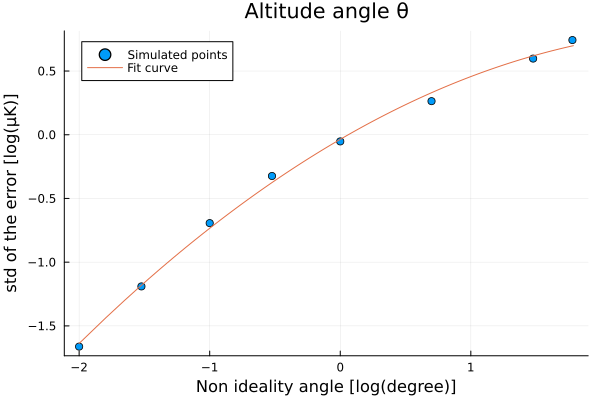

In [81]:
scatter(log_angle, log_error, xlabel="Non ideality angle [log(degree)]", ylabel="std of the error [log(μK)]", label = "Simulated points")
plot!(xdata, model_linear(xdata, fit_linear.param), label = "Fit curve", title="Altitude angle θ")

# Ground offset angle

In [7]:
tel_angs_ground = []
for i in errored_angles_deg
    push!(tel_angs_ground, Sl.TelescopeAngles(wheel3ang_0_rad = deg2rad(i)))
end
result_ground = run_scaling(tel_angs_ground, sky_model, nside)

([0.11307546984055582, 0.3391897806560659, 1.1530441174890407, 3.4299455029504418, 8.756763019537313, 21.077135549428437, 44.48711370395888, 53.335131660638595], [0.006776839224937899, 0.020304340278291446, 0.0686431652250647, 0.21050857359395378, 0.5158104953460051, 1.1448336717128216, 2.6435090234586496, 3.543898801413793], [0.00947953224651634, 0.028430729510575087, 0.09624510709849003, 0.29516081808344474, 0.7237280516638399, 1.5712737760272801, 3.286710828958154, 4.1245713471347605])

In [65]:
@. model_linear(x,p) = p[1]*x^2 + p[2]*x + p[3]
log_error = log.(result_ground[1])
log_angle = log.(errored_angles_deg)
fit_linear = curve_fit(model_linear, log_angle, log_error, [0.0, 0.5, 1.0])
print(fit_linear.param)

[-0.05574860509114775, 0.6886736311725316, 2.1003418933956404]

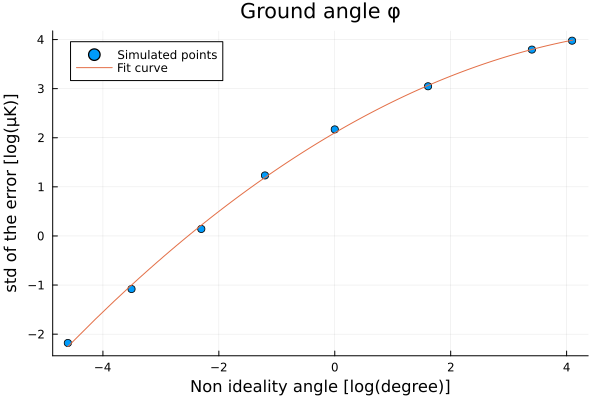

In [66]:
scatter(log_angle, log_error, xlabel="Non ideality angle [log(degree)]", ylabel="std of the error [log(μK)]", label = "Simulated points")
plot!(xdata, model_linear(xdata, fit_linear.param), label = "Fit curve", title = "Ground angle φ")

# Fork angle

In [10]:
tel_angs_fork = []
for i in errored_angles_deg
    push!(tel_angs_fork, Sl.TelescopeAngles(forkang_rad = deg2rad(i)))
end
result_fork = run_scaling(tel_angs_fork, sky_model, nside)

([0.31008317707652316, 0.9386755989543215, 3.2007966251780786, 7.907915348494621, 15.395209431118214, 32.85787121503453, 61.235392397721355, 80.2030886657832], [0.01860728479167842, 0.05627777450226168, 0.19458963112470987, 0.4599055872838576, 0.8670775753251243, 1.8569076267730438, 4.614725660078179, 5.42400507190947], [0.02605977724941808, 0.07889944088436064, 0.2727953261295908, 0.644993977146638, 1.2032603896720981, 2.4468267981958856, 5.026693707515696, 7.902359951913158])

In [67]:
@. model_linear(x,p) = p[1]*x^2 + p[2]*x + p[3]
log_error = log.(result_fork[1])
log_angle = log.(errored_angles_deg)
fit_linear = curve_fit(model_linear, log_angle, log_error, [0.0, 0.5, 1.0])
print(fit_linear.param)

[-0.05475994736564717, 0.5989602176709482, 2.765702816729636]

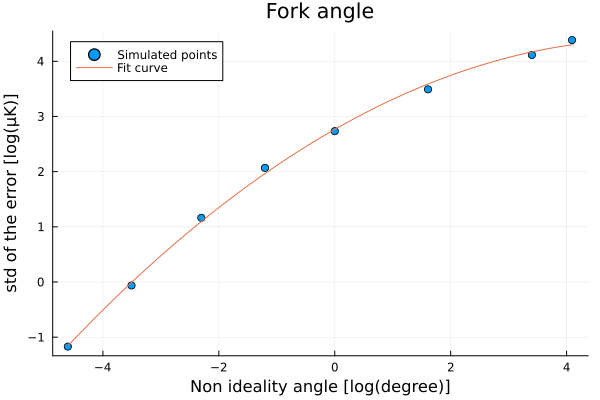

In [68]:
scatter(log_angle, log_error, xlabel="Non ideality angle [log(degree)]", ylabel="std of the error [log(μK)]", label = "Simulated points")
plot!(xdata, model_linear(xdata, fit_linear.param), label = "Fit curve", title = "Fork angle")

# Wobble angles

In [16]:
tel_angs_0 = []
tel_angs_90 = []
tel_angs_180 = []
tel_angs_270 = []

for i in errored_angles_deg
    push!(tel_angs_0, Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(0.0)))
    push!(tel_angs_90, Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(90.0)))
    push!(tel_angs_180, Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(180.0)))
    push!(tel_angs_270, Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(270.0)))
end

result_0 = run_scaling(tel_angs_0, sky_model, nside)
result_90 = run_scaling(tel_angs_90, sky_model, nside)
result_180 = run_scaling(tel_angs_180, sky_model, nside)
result_270 = run_scaling(tel_angs_270, sky_model, nside)

([8.458426204289632e-5, 0.0007612586278232293, 0.008458667297286988, 0.07613676020397563, 0.850288188223567, 11.196101813148658, 54.95080621087456, 51.67559237488495], [5.395514790159894e-6, 4.855959918895818e-5, 0.0005394329704825576, 0.004846091806071623, 0.053264967510273376, 0.6935845698959525, 3.6792470505794523, 6.147015258291282], [7.324888656675217e-6, 6.59239797683422e-5, 0.0007324334933003605, 0.006583822975414227, 0.07267213423875593, 1.0166338723003452, 4.256870176476081, 6.367764017931785])

In [44]:
@. model_linear(x,p) = p[1]*x^2 + p[2]*x + p[3]
log_angle = log.(errored_angles_deg)

log_error_0 = log.(result_0[1])
log_error_90 = log.(result_90[1])
log_error_180 = log.(result_180[1])
log_error_270 = log.(result_270[1])

fit_linear_0 = curve_fit(model_linear, log_angle, log_error_0, [0.0, 1.0, 1.0])
fit_linear_90 = curve_fit(model_linear, log_angle, log_error_90, [0.0, 1.0, 1.0])
fit_linear_180 = curve_fit(model_linear, log_angle, log_error_180, [0.0, 1.0, 1.0])
fit_linear_270 = curve_fit(model_linear, log_angle, log_error_270, [0.0, 1.0, 1.0])

print(fit_linear_0.param)
print(fit_linear_90.param)
print(fit_linear_180.param)
print(fit_linear_270.param)

[-0.09777497401280881, 1.6005029903002654, -0.4219540931323786][-0.07854150343378108, 1.6665103649347661, -0.724881604919324][-0.09424951372514556, 1.6165534667393855, -0.5167610536302674][-0.10503032679685995, 1.558416183299696, -0.28859360407114804]

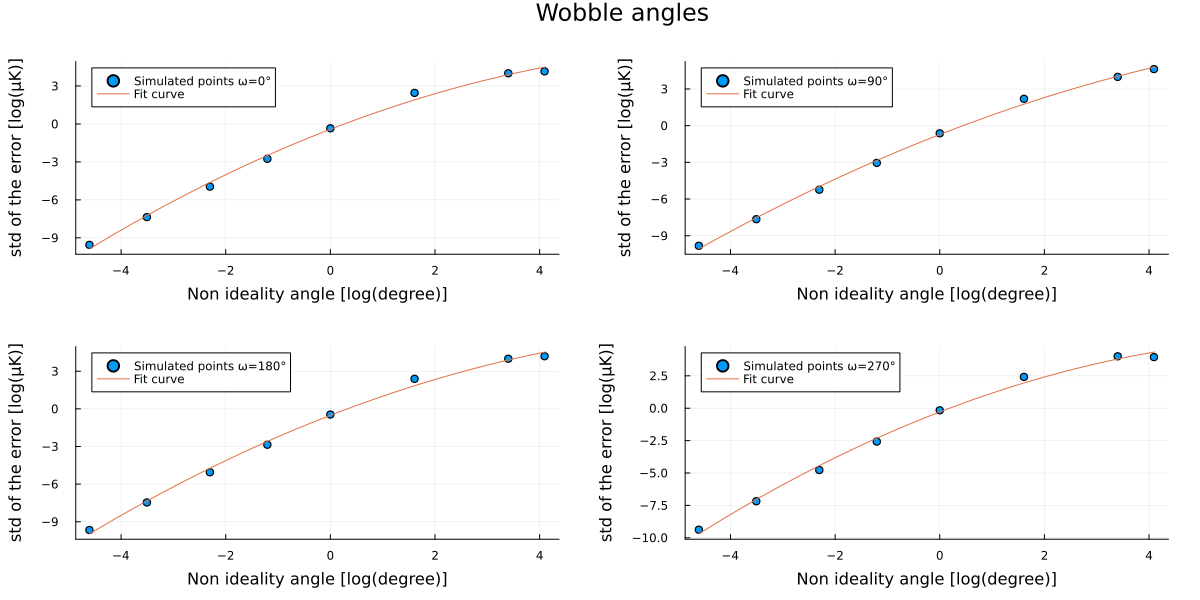

In [56]:

a = scatter(log_angle, log_error_0, xlabel="Non ideality angle [log(degree)]", ylabel="std of the error [log(μK)]", label = "Simulated points ω=0°")
a = plot!(xdata, model_linear(xdata, fit_linear_0.param), label = "Fit curve")

b = scatter(log_angle, log_error_90, xlabel="Non ideality angle [log(degree)]", ylabel="std of the error [log(μK)]", label = "Simulated points ω=90°")
b = plot!(xdata, model_linear(xdata, fit_linear_90.param), label = "Fit curve")

c = scatter(log_angle, log_error_180, xlabel="Non ideality angle [log(degree)]", ylabel="std of the error [log(μK)]", label = "Simulated points ω=180°")
c = plot!(xdata, model_linear(xdata, fit_linear_180.param), label = "Fit curve")

d = scatter(log_angle, log_error_270, xlabel="Non ideality angle [log(degree)]", ylabel="std of the error [log(μK)]", label = "Simulated points ω=270°")
d = plot!(xdata, model_linear(xdata, fit_linear_270.param), label = "Fit curve")

plot(a,b,c,d, layaut = (4,1), size = (1200,600), margin = 6*Plots.mm, plot_title="Wobble angles")